## Question 1

In [17]:
using JuMP, Clp, ECOS, SCS

In [7]:
m = Model()
@variable(m, 0 <= x1 <= 3)
@variable(m, 0 <= x2 <= 3)
@variable(m, 0 <= x3 <= 3)

@constraint(m, 2x1 >= x2 + x3)
@objective(m, Max, 5x1 - x2 + 11x3)

5 x1 - x2 + 11 x3

### Solve using Clp

In [8]:
setsolver(m, ClpSolver())
@time(solve(m))
getobjectivevalue(m)

  4.357362 seconds (4.18 M allocations: 172.616 MB, 1.85% gc time)


48.0

### Solve using ECOS

In [9]:
setsolver(m, ECOSSolver())
@time(solve(m))
getobjectivevalue(m)

 
ECOS 2.0.5 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  -2.250e+01  -8.440e+01  +1e+02  2e-01  3e-01  1e+00  1e+01    ---    ---    1  1  - |  -  - 
 1  -4.615e+01  -5.603e+01  +2e+01  2e-02  6e-02  7e-01  3e+00  0.8410  6e-02   0  0  0 |  0  0
 2  -4.726e+01  -4.850e+01  +3e+00  3e-03  8e-03  2e-01  4e-01  0.9283  7e-02   0  0  0 |  0  0
 3  -4.799e+01  -4.803e+01  +8e-02  1e-04  2e-04  7e-03  1e-02  0.9798  9e-03   1  0  0 |  0  0
 4  -4.800e+01  -4.800e+01  +9e-04  1e-06  3e-06  8e-05  1e-04  0.9890  1e-04   1  0  0 |  0  0
 5  -4.800e+01  -4.800e+01  +9e-06  1e-08  3e-08  9e-07  1e-06  0.9890  1e-04   1  0  0 |  0  0
 6  -4.800e+01  -4.800e+01  +1e-07  1e-10  3e-10  1e-08  1e-08  0.9890  1e-04   1  0  0 |  0  0

OPTIMAL (within feastol=3.3e-10, reltol=2.2e-09, abstol=1.0e-07).
Runtime: 0.000131 seconds.

 

### Solve using SCS

In [10]:
setsolver(m, SCSSolver())
@time(solve(m))
getobjectivevalue(m)

 ----------------------------------------------------------------------------
	SCS v1.1.8 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2015
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 9
eps = 1.00e-04, alpha = 1.80, max_iters = 20000, normalize = 1, scale = 5.00
Variables n = 3, constraints m = 7
Cones:	linear vars: 7
Setup time: 4.94e-05s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0|      inf       inf      -nan      -inf      -nan       inf  8.31e-05 
   100| 8.00e-05  1.91e-04  8.48e-06 -4.80e+01 -4.80e+01  2.69e-15  1.48e-04 
   140| 4.49e-06  2.70e-06  1.09e-07 -4.80e+01 -4.80e+01  0.00e+00  1.75e-04 
----------------------------------------------------------------------------
Status: Solved
Ti

### Analysis
The CLP solver is by far the most accurate and fastest of the three solvers. This is probably because it is designed to solve only linear programs, while the other two solvers are more generic and can solve both linear programs and second order cone programs. (Note the SCS solver gets a higher objective value than CLP, but CLP found an optimal solution. This comes from numerical error causing SCS to find an infeasible solution)

x3 is in the infeasible region

In [11]:
getvalue(x3)

3.0000130627112176

## Question 2

### a)

Since $z_1$ is unconstrained, we redefine it as $z_1 = y - w$ where $y \geq 0 , w \geq 0$
Then to make all the rest of the variables non-negative, we simply shift there value.

$z'_2 = z_2 + 1$

$z'_3 = z_3 + 1$

$z'_4 = z_4 + 2$

Then we turn the rest of the constraints into equalities using non-negative surplus and slack variables.

$-y + w + 6z'_2 - z'_3 + z'_4 - s_1 = 4$

$7z'_2 + z'_4 = 14$

$z'_3 + z'_4 + s_2 = 5$

$z'_2 + s_3 = 6$

$z'_3 + s_4 = 6$

$z'_4 + s_5 = 4$

This gives us our variable array,

$x = \begin{bmatrix}
y \\
w \\
z'_2 \\
z'_3 \\
z'_4 \\
s_1 \\
s_2 \\
s_3 \\
s_4 \\
s_5 \\
\end{bmatrix}$

equality equations defined by,

$ A = \begin{bmatrix}
-1 & 1 & 6 & -1 & 1 & -1 & 0 & 0 & 0 & 0\\
0 & 0 & 0 & 1 & 1 & 0 & 1 & 0 & 0 & 0 \\
0 & 0 & 7 & 0 & 1 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 1 & 0 & 0 & 0 & 0 & 1 & 0 & 0 \\
0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 & 1 & 0 \\
0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 & 1 \\
\end{bmatrix}$

$b = \begin{bmatrix}
4\\
5\\
14 \\ 
6\\
6\\
4 \\
\end{bmatrix}$

Finally our new objective function is

$ -3y + 3w + z'_2$

minimizing this vector will maximize the orignal objective function since,

$-3y + 3w + z'_2 = -(3z_1 - z_2) + 1$

so our objective vector is,

$c= \begin{bmatrix}
-3 \\
3 \\
1 \\
0 \\
0 \\
0 \\
0 \\
0\\
0\\
0\\
\end{bmatrix}$

### b)

#### Solving in non standard form

In [12]:
ns_m = Model()
@variable(ns_m, z1)
@variable(ns_m, -1 <= z2 <= 5)
@variable(ns_m, -1 <= z3 <= 5)
@variable(ns_m, -2 <= z4 <= 2)
@constraint(ns_m, -z1 + 6z2  - z3 + z4 >= -3)
@constraint(ns_m, 7z2 + z4 == 5)
@constraint(ns_m, z3 + z4 <= 2)
@objective(ns_m, Max, 3z1 - z2)
solve(ns_m)

:Optimal

In [23]:
println("z1 = ", getvalue(z1))
println("z2 = ", getvalue(z2))
println("z3 = ", getvalue(z3))
println("z4 = ", getvalue(z4))
println("objective = ", getobjectivevalue(ns_m))

z1 = 8.571428571428571
z2 = 0.42857142857142855
z3 = -1.0
z4 = 2.0
objective = 25.28571428571429


#### Solving standard form

In [32]:
A = [
    -1 1 6 -1 1 -1 0 0 0 0;
    0 0 0 1 1 0 1 0 0 0;
    0 0 7 0 1 0 0 0 0 0;
    0 0 1 0 0 0 0 1 0 0;
    0 0 0 1 0 0 0 0 1 0;
    0 0 0 0 1 0 0 0 0 1;
]
b = [4; 5; 14 ; 6; 6; 4;]
c = [-3; 3; 1; 0; 0; 0; 0; 0; 0; 0 ;]

s_m = Model()
@variable(s_m, x[1:10] >= 0)
@constraint(s_m, A*x .== b)
@objective(s_m, Min, (c'*x)[1])
solve(s_m)

:Optimal

With slight modifications to solution we aquire the same values and objective value as non standard model.

In [35]:
x_value = getvalue(x)
println("z1 = ", x_value[1] - x_value[2])
println("z2 = ", x_value[3] -1)
println("z3 = ",x_value[4] - 1)
println("z4 = ", x_value[5] -2)
println("objective =", -getobjectivevalue(s_m) + 1)


z1 = 8.571428571428571
z2 = 0.4285714285714286
z3 = -1.0
z4 = 2.0
objective =25.28571428571429


## Question 3
### a)

In [37]:
workers = 100
fertilizer = 120 
acres = 45
wheat_profit = 200
corn_profit = 300

crop_m = Model()
@variable(crop_m, corn >= 0)
@variable(crop_m, wheat >= 0)
@constraint(crop_m, corn + wheat <= acres)
@constraint(crop_m, 3wheat + 2corn <= workers)
@constraint(crop_m, 2wheat + 4corn <= fertilizer)
@objective(crop_m, Max, corn * corn_profit + wheat * wheat_profit)

300 corn + 200 wheat

In [40]:
solve(crop_m)
println("wheat = ", getvalue(wheat))
println("corn = ", getvalue(corn))
println("total profit = ",getobjectivevalue(crop_m))

wheat = 19.999999999999996
corn = 20.0
total profit = 10000.0


### b)

In [1]:
using PyPlot

As you can see in the plot below of all the boundaries, the profit level set of 10000 has only one feasible point which is at Corn = 20 and Wheat = 20. Any higher profit level set would be pushed past the feasible region.

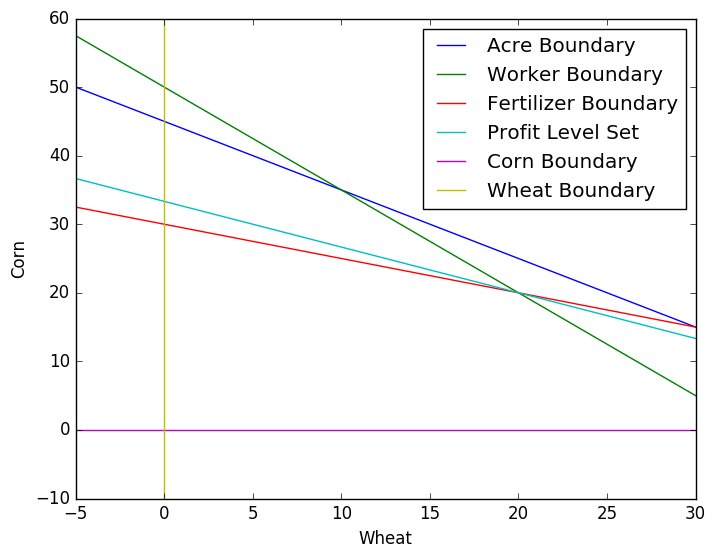

PyObject <matplotlib.legend.Legend object at 0x7f503a3a15f8>

In [20]:
w = linspace(-5,30,2)
c = linspace(-10,60,2)
acre_line = 45 - w
worker_line = (100 - 3w)/2
fertilizer_line = (120 - 2w)/4
profit_line = (10000-200w)/300
plot(w,acre_line, label = "Acre Boundary")
plot(w,worker_line, label = "Worker Boundary")
plot(w,fertilizer_line, label="Fertilizer Boundary")
plot(w, profit_line, label="Profit Level Set")
plot(w,zeros(w), label= "Corn Boundary")
plot(zeros(c),c, label="Wheat Boundary")
xlabel("Wheat")
ylabel("Corn")
legend()

## Question 4

In [35]:
C = [0.025 ; 0.03; 0 ; 0 ; 0 ; 0 ; 0]
Cu = [0; 0 ; 0.003; 0.9; .96; 0.004; 0.006]
Mn = [0.013 ; 0.008; 0 ; 0 ;0.04; 0.012; 0]
Avail = [400; 300; 600; 500; 200; 300; 250]
Cost = [200; 250; 150; 220; 240; 200; 165]
dummySum = [1; 1; 1; 1; 1; 1; 1]
steelOrdered = 500

material_names = ["Iron allow 1", "Iron allow 2", "Iron allow 3", "Copper 1", "Copper 2", "Aluminum 1", "Aluminum 2"]

steel_m = Model()
@variable(steel_m, x[1:7] >= 0)
@constraint(steel_m, dot(dummySum,x) == steelOrdered)
@constraint(steel_m, 0.02 <= dot(C,x)/steelOrdered <= 0.03)
@constraint(steel_m, 0.004 <= dot(Cu,x)/steelOrdered <= 0.006)
@constraint(steel_m, 0.012 <= dot(Mn,x)/steelOrdered <= 0.0165)
@constraint(steel_m, x .<= Avail)
@objective(steel_m, Min, dot(Cost,x))

solve(steel_m)

println("Cost = ", getobjectivevalue(steel_m))
x = getvalue(x)
for i in 1:7
    println(material_names[i] , " = ", x[i])
end

Cost = 98121.63579168123
Iron allow 1 = 400.0
Iron allow 2 = 0.0
Iron allow 3 = 39.77630199231035
Copper 1 = 0.0
Copper 2 = 2.761272282418734
Aluminum 1 = 57.462425725270904
Aluminum 2 = 0.0
